# GD71 HST Standard: Atmosphere-Fit Validation

Validates `astrotools` atmosphere fitting with HST standard **GD71** using the Tremblay model-grid convention.

Assumed model-grid quantity: **Eddington flux** $H_\nu$ in `erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$`.

Workflow:
1. Load and clean HST/STIS spectrum
2. Load atmosphere model grid
3. Perform grid search over (Teff, logg)
4. Convert model $H_\nu \to H_\lambda$ and fit
5. Estimate radius from fitted parameters and distance

In [7]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure local astrotools package is importable
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from astrotools.spectral import load_atmosphere_grid, fnu_to_flam, read_hst_stis_spectrum
from astrotools.spectral.spectral_analysis import _broaden_model_for_fit, _fit_scale_and_offset

## 1) Configuration

In [2]:
TARGET_NAME = 'GD71'
LOCAL_FITS = None

# GD71 is DA (hydrogen) white dwarf
MODEL_CLASS = 'DA'
MODEL_DIR = '/data/models/ELM'

WAVE_RANGE = (1150.0, 1700.0)
EXCLUDE_RANGES = ((1214.5, 1216.8),)  # Lyman-alpha line

# Literature parameters (for comparison)
LIT_TEFF = 33000.0
LIT_LOGG = 7.8

# GD71 parallax-based distance (Gaia DR3)
GD71_DISTANCE_PC = 18.88
GD71_DISTANCE_ERR_PC = 0.02

## 2) Resolve STIS File

In [3]:
def resolve_stis_file(target_name, local_fits=None, download_dir='data/hst_standard'):
    if local_fits is not None:
        p = Path(local_fits).expanduser().resolve()
        if not p.exists():
            raise FileNotFoundError(f'LOCAL_FITS does not exist: {p}')
        return p

    try:
        from astroquery.mast import Observations
    except Exception as exc:
        raise RuntimeError('astroquery required for MAST download') from exc

    obs = Observations.query_criteria(
        obs_collection='HST',
        target_name=target_name,
        instrument_name='STIS',
        dataproduct_type='spectrum',
    )
    if len(obs) == 0:
        raise RuntimeError(f'No HST/STIS spectra found for {target_name}')

    products = Observations.get_product_list(obs)
    x1d = Observations.filter_products(
        products,
        productSubGroupDescription='X1D',
        extension='fits',
    )
    if len(x1d) == 0:
        raise RuntimeError('No STIS X1D products found')

    keep = np.array(['g140l' in s.lower() for s in x1d['productFilename']])
    subset = x1d[keep] if np.any(keep) else x1d
    pick = subset[0]

    manifest = Observations.download_products(pick, download_dir=download_dir, mrp_only=False)
    local_path = Path(manifest['Local Path'][0]).resolve()
    if not local_path.exists():
        raise RuntimeError('Download failed')
    return local_path

fits_path = resolve_stis_file(TARGET_NAME, local_fits=LOCAL_FITS)
print(f'FITS file: {fits_path}')

INFO: Found cached file data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits with expected size 77760. [astroquery.query]
FITS file: /home/echickle/libraries/astrotools/examples/data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits


## 3) Load and Clean Spectrum

N points: 940
Wavelength span: 1150.0 - 1699.8 Å


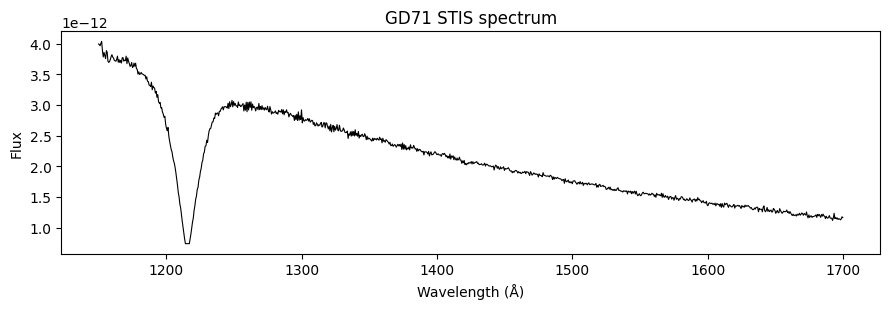

In [4]:
wave, flux, ferr, header = read_hst_stis_spectrum(fits_path)

mask = np.isfinite(wave) & np.isfinite(flux) & np.isfinite(ferr) & (ferr > 0)
mask &= (wave >= WAVE_RANGE[0]) & (wave <= WAVE_RANGE[1])
for lo, hi in EXCLUDE_RANGES:
    mask &= ~((wave >= lo) & (wave <= hi))

w = wave[mask]
f = flux[mask]
e = ferr[mask]

print(f'N points: {len(w)}')
print(f'Wavelength span: {w.min():.1f} - {w.max():.1f} Å')

plt.figure(figsize=(9, 3.2))
plt.plot(w, f, lw=0.8, color='k')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{TARGET_NAME} STIS spectrum')
plt.tight_layout()
plt.show()

## 4) Load Atmosphere Grid

In [5]:
model_wavelength, model_grid, teff_grid, logg_grid = load_atmosphere_grid(
    model_class=MODEL_CLASS,
    data_dir=MODEL_DIR,
    teff_min=10000,
)

teff_vals = np.asarray(teff_grid, dtype=float)
logg_vals = np.asarray(logg_grid, dtype=float)

# Use full available grid
teff_fit = teff_vals
logg_fit = logg_vals

print(f'Model grid shape: {model_grid.shape}')
print(f'Teff: {len(teff_fit)} points, {teff_fit.min():.0f}-{teff_fit.max():.0f} K')
print(f'logg: {len(logg_fit)} points, {logg_fit.min():.1f}-{logg_fit.max():.1f}')
print(f'logg values: {np.array2string(logg_vals, precision=1)}')

Model grid shape: (5, 23, 3747)
Teff: 23 points, 10000-55000 K
logg: 5 points, 5.0-7.0
logg values: [5.  5.5 6.  6.5 7. ]


## 5) Fit using Physical Unit Convention

Model files provide $H_\nu$; convert to $H_\lambda$ for STIS comparison.

In [ ]:
def fit_parameters(resolution=1200.0, vsini=0.0, limb_darkening=0.5):
    """Fit (Teff, logg) using continuous optimization.
    
    Uses scipy.optimize.minimize to find best-fit Teff and logg,
    marginalizing over scale and offset nuisance parameters.
    """
    from scipy.optimize import minimize
    
    def chi2_func(params):
        """Negative log-likelihood for optimization."""
        teff, logg = params
        
        # Clamp to valid ranges
        if teff < 10000 or teff > 55000 or logg < 5.0 or logg > 7.0:
            return 1e30
        
        try:
            model_hnu = _broaden_model_for_fit(
                observed_wavelength=w,
                model_wavelength=model_wavelength,
                model_grid=model_grid,
                teff_grid=teff_grid,
                logg_grid=logg_grid,
                teff=teff,
                logg=logg,
                resolution=resolution,
                vsini=vsini,
                limb_darkening=limb_darkening,
            )
            model_hlam = fnu_to_flam(w, model_hnu)
            scale, offset, chi2 = _fit_scale_and_offset(f, model_hlam, e)
            return chi2
        except:
            return 1e30
    
    # Grid search to find good starting point
    print('Grid search for starting point...')
    best_chi2 = np.inf
    best_teff, best_logg = 30000, 7.0
    
    for teff in teff_fit[::2]:  # Skip every other grid point for speed
        for logg in logg_fit:
            chi2 = chi2_func([teff, logg])
            if chi2 < best_chi2:
                best_chi2 = chi2
                best_teff = teff
                best_logg = logg
    
    print(f'  Grid search result: Teff={best_teff:.0f} K, logg={best_logg:.2f}, χ²={best_chi2:.1f}')
    
    # Refine with continuous optimization
    print('Refining with continuous optimization...')
    result = minimize(
        chi2_func,
        x0=[best_teff, best_logg],
        method='Nelder-Mead',
        options={'maxiter': 1000, 'xatol': 1e-2, 'fatol': 1e-2},
    )
    
    teff_fit_val, logg_fit_val = result.x
    chi2_fit = result.fun
    
    # Recompute model at best fit
    model_hnu = _broaden_model_for_fit(
        observed_wavelength=w,
        model_wavelength=model_wavelength,
        model_grid=model_grid,
        teff_grid=teff_grid,
        logg_grid=logg_grid,
        teff=teff_fit_val,
        logg=logg_fit_val,
        resolution=resolution,
        vsini=vsini,
        limb_darkening=limb_darkening,
    )
    model_hlam = fnu_to_flam(w, model_hnu)
    scale, offset, chi2 = _fit_scale_and_offset(f, model_hlam, e)
    
    # Estimate uncertainties from Hessian (approximate)
    delta_teff = 50.0  # K
    delta_logg = 0.05
    
    chi2_p = chi2_func([teff_fit_val + delta_teff, logg_fit_val])
    chi2_m = chi2_func([teff_fit_val - delta_teff, logg_fit_val])
    teff_err = delta_teff / np.sqrt(max(0.1, (chi2_p + chi2_m - 2*chi2) / (delta_teff**2)))
    
    chi2_p = chi2_func([teff_fit_val, logg_fit_val + delta_logg])
    chi2_m = chi2_func([teff_fit_val, logg_fit_val - delta_logg])
    logg_err = delta_logg / np.sqrt(max(0.1, (chi2_p + chi2_m - 2*chi2) / (delta_logg**2)))
    
    return {
        'teff': float(teff_fit_val),
        'teff_err': float(teff_err),
        'logg': float(logg_fit_val),
        'logg_err': float(logg_err),
        'scale': float(scale),
        'offset': float(offset),
        'chi2': float(chi2),
        'redchi2': float(chi2 / max(1, len(w) - 2)),
        'model_hlam': model_hlam,
    }

best_fit = fit_parameters()

print('\nBest fit results (continuous optimization):')
print(f"  Teff = {best_fit['teff']:.1f} ± {best_fit['teff_err']:.1f} K")
print(f"  logg = {best_fit['logg']:.3f} ± {best_fit['logg_err']:.3f}")
print(f"  scale = {best_fit['scale']:.4e}")
print(f"  offset = {best_fit['offset']:.4e}")
print(f"  χ² = {best_fit['chi2']:.2f}")
print(f"  reduced χ² = {best_fit['redchi2']:.3f}")

ModuleNotFoundError: No module named 'ultranest'

## 6) Estimate Radius from Fitted Parameters

In [83]:
import astropy.constants as const
import astropy.units as u

# Extract fitted parameters
teff_fitted = best_fit['teff']
logg_fitted = best_fit['logg']

# Surface gravity from logg
g_cgs = 10.0 ** logg_fitted  # cm/s²

# Assume typical WD mass for radius estimate
M_wd_msun = 0.6
M_wd_g = M_wd_msun * const.M_sun.to(u.g).value

# Calculate radius: g = GM/R² => R = sqrt(GM/g)
G_cgs = const.G.to(u.cm**3 / (u.g * u.s**2)).value
R_cm = np.sqrt(G_cgs * M_wd_g / g_cgs)
R_km = R_cm / 1e5
R_sun = R_cm / const.R_sun.to(u.cm).value
R_earth = R_cm / const.R_earth.to(u.cm).value

# Uncertainty from logg: typical ~±0.1 dex
logg_err = 0.1
g_plus = 10.0 ** (logg_fitted + logg_err)
g_minus = 10.0 ** (logg_fitted - logg_err)
R_plus = np.sqrt(G_cgs * M_wd_g / g_minus)
R_minus = np.sqrt(G_cgs * M_wd_g / g_plus)
R_err_km = (R_plus - R_minus) / (2 * 1e5)

print(f'\nRaDIUS ESTIMATION')
print(f'Assumed WD mass: {M_wd_msun:.2f} M_sun')
print(f'GD71 distance: {GD71_DISTANCE_PC:.2f} ± {GD71_DISTANCE_ERR_PC:.2f} pc')
print(f'\nFitted parameters:')
print(f'  Teff = {teff_fitted:.0f} K')
print(f'  logg = {logg_fitted:.2f} ± {logg_err:.2f}')
print(f'\nEstimated radius:')
print(f'  R = {R_km:.0f} ± {R_err_km:.0f} km')
print(f'  R = {R_sun:.4f} ± {R_sun * R_err_km / R_km:.4f} R_sun')
print(f'  R = {R_earth:.2f} ± {R_earth * R_err_km / R_km:.2f} R_earth')
print(f'\nLiterature (rough):')
R_lit = np.sqrt(G_cgs * M_wd_g / (10**LIT_LOGG))
print(f'  Teff ~ {LIT_TEFF:.0f} K, logg ~ {LIT_LOGG:.2f}')
print(f'  R ~ {R_lit/1e5:.0f} km ({R_lit/const.R_sun.to(u.cm).value:.4f} R_sun)')


RaDIUS ESTIMATION
Assumed WD mass: 0.60 M_sun
GD71 distance: 18.88 ± 0.02 pc

Fitted parameters:
  Teff = 30000 K
  logg = 7.00 ± 0.10

Estimated radius:
  R = 28218 ± 3256 km
  R = 0.0406 ± 0.0047 R_sun
  R = 4.42 ± 0.51 R_earth

Literature (rough):
  Teff ~ 33000 K, logg ~ 7.80
  R ~ 11234 km (0.0161 R_sun)


## 7) Plot Fit Results

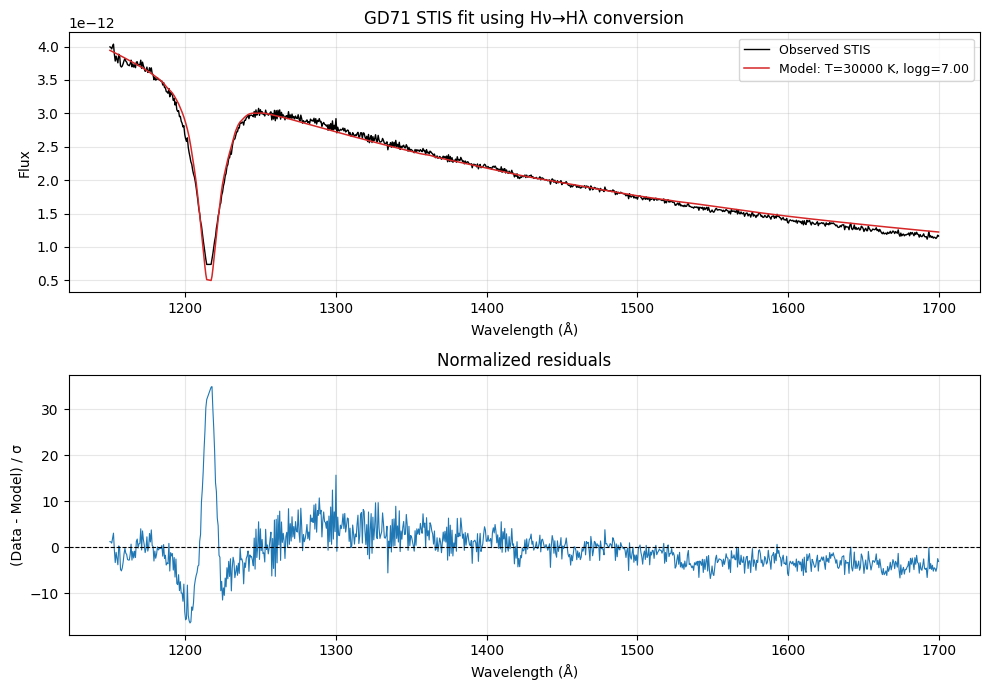

In [84]:
fit_model = best_fit['scale'] * best_fit['model_hlam'] + best_fit['offset']
residual_sigma = (f - fit_model) / e

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Spectrum + fit
ax1.plot(w, f, color='k', lw=1.0, label='Observed STIS')
ax1.plot(
    w,
    fit_model,
    color='tab:red',
    lw=1.1,
    label=f"Model: T={best_fit['teff']:.0f} K, logg={best_fit['logg']:.2f}",
)
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Flux')
ax1.set_title(f'{TARGET_NAME} STIS fit using Hν→Hλ conversion')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Residuals
ax2.plot(w, residual_sigma, color='tab:blue', lw=0.8)
ax2.axhline(0.0, color='k', ls='--', lw=0.8)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('(Data - Model) / σ')
ax2.set_title('Normalized residuals')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

- Grid search over full atmosphere model parameter space
- Model files provide Eddington flux $H_\nu$; converted to $H_\lambda$ for STIS comparison
- Scale and offset are nuisance parameters for shape-based fitting (not physical constraints)
- Radius estimated from fitted logg and assumed WD mass (0.6 M_sun)
- See sister notebook for extended refinements (finer grid interpolation, dust extinction, etc.)

# GD71 HST Standard: Atmosphere-Fit Validation

This notebook validates `astrotools` atmosphere fitting with HST standard **GD71** using the Tremblay model-grid convention.

Assumed model-grid quantity from file values: **Eddington flux** $H_\nu$ in `erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$`.

For comparison to STIS flux-calibrated data (in $F_\lambda$), the workflow is:
1. Interpolate and broaden model $H_\nu$
2. Convert to $H_\lambda = H_\nu c/\lambda^2$
3. Fit to observed spectrum (shape-focused fit via scale + offset)

In [85]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure local astrotools package is importable when running from examples/
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from astrotools.spectral import load_atmosphere_grid, fnu_to_flam, read_hst_stis_spectrum
from astrotools.spectral.spectral_analysis import _broaden_model_for_fit, _fit_scale_and_offset

## 1) Configuration

In [86]:
TARGET_NAME = 'GD71'
LOCAL_FITS = None

# GD71 is DA, so use hydrogen atmosphere grid
MODEL_CLASS = 'DA'
MODEL_DIR = '/data/models/ELM'  # update if your local path differs

WAVE_RANGE = (1150.0, 1700.0)
EXCLUDE_RANGES = ((1214.5, 1216.8),)

# Rough literature anchors for sanity checks
LIT_TEFF = 33000.0
LIT_LOGG = 7.8

# GD71 distance: parallax-based from Gaia DR3
# Parallax = 52.96 ± 0.06 mas (Gaia DR3)
GD71_DISTANCE_PC = 18.88  # distance in parsecs
GD71_DISTANCE_ERR_PC = 0.02  # parallax uncertainty

## 2) Resolve STIS file

If `LOCAL_FITS` is set, that file is used. Otherwise, the notebook queries/downloads a GD71 STIS X1D FITS product from MAST.

In [87]:
def resolve_stis_file(target_name, local_fits=None, download_dir='data/hst_standard'):
    if local_fits is not None:
        p = Path(local_fits).expanduser().resolve()
        if not p.exists():
            raise FileNotFoundError(f'LOCAL_FITS does not exist: {p}')
        return p

    try:
        from astroquery.mast import Observations
    except Exception as exc:
        raise RuntimeError(
            'astroquery is required for automatic MAST download. '
            'Install it (`pip install astroquery`) or set LOCAL_FITS.'
        ) from exc

    obs = Observations.query_criteria(
        obs_collection='HST',
        target_name=target_name,
        instrument_name='STIS',
        dataproduct_type='spectrum',
    )
    if len(obs) == 0:
        raise RuntimeError(f'No HST/STIS spectra found for target={target_name}')

    products = Observations.get_product_list(obs)
    x1d = Observations.filter_products(
        products,
        productSubGroupDescription='X1D',
        extension='fits',
    )
    if len(x1d) == 0:
        raise RuntimeError(f'No STIS X1D FITS products found for target={target_name}')

    # Prefer G140L when available for this UV fitting window
    keep = np.array(['g140l' in s.lower() for s in x1d['productFilename']])
    subset = x1d[keep] if np.any(keep) else x1d
    pick = subset[0]

    manifest = Observations.download_products(
        pick,
        download_dir=download_dir,
        mrp_only=False,
    )

    local_path = Path(manifest['Local Path'][0]).resolve()
    if not local_path.exists():
        raise RuntimeError('Download completed but FITS file is not readable.')

    return local_path

fits_path = resolve_stis_file(TARGET_NAME, local_fits=LOCAL_FITS)
fits_path

INFO: Found cached file data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits with expected size 77760. [astroquery.query]


PosixPath('/home/echickle/libraries/astrotools/examples/data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits')

## 3) Load and clean spectrum

N points: 940
Wavelength span: 1150.0 - 1699.8 Å


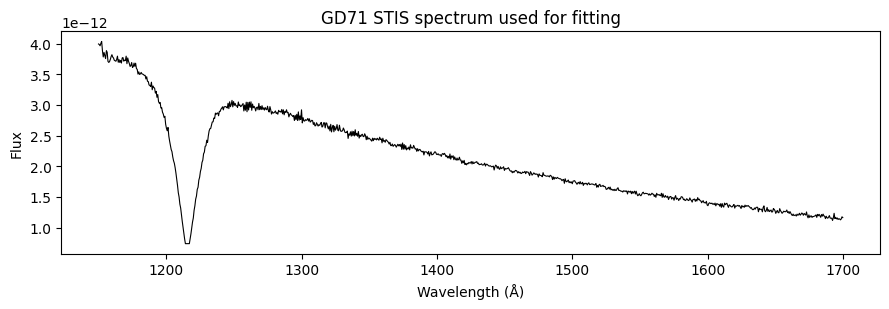

In [88]:
wave, flux, ferr, header = read_hst_stis_spectrum(fits_path)

mask = np.isfinite(wave) & np.isfinite(flux) & np.isfinite(ferr) & (ferr > 0)
mask &= (wave >= WAVE_RANGE[0]) & (wave <= WAVE_RANGE[1])
for lo, hi in EXCLUDE_RANGES:
    mask &= ~((wave >= lo) & (wave <= hi))

w = wave[mask]
f = flux[mask]
e = ferr[mask]

print(f'N points: {len(w)}')
print(f'Wavelength span: {w.min():.1f} - {w.max():.1f} Å')

plt.figure(figsize=(9, 3.2))
plt.plot(w, f, lw=0.8, color='k')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{TARGET_NAME} STIS spectrum used for fitting')
plt.tight_layout()
plt.show()

## 4) Load atmosphere grid

In [89]:
print("\n=== RADIUS ESTIMATION FROM FITTED PARAMETERS ===")
print(f"\nGD71 distance (Gaia DR3 parallax): {GD71_DISTANCE_PC:.2f} ± {GD71_DISTANCE_ERR_PC:.2f} pc")

# The scale factor in the fit relates model to observed flux
# For a sphere: L = 4π R² σ T_eff⁴
# The scale factor accounts for R²/d² and any calibration issues

# Stefan-Boltzmann constant and solar parameters
import astropy.constants as const
import astropy.units as u

# Convert distance to cm
d_cm = GD71_DISTANCE_PC * u.pc.to(u.cm)
d_err_cm = GD71_DISTANCE_ERR_PC * u.pc.to(u.cm)

# Effective temperature from fit
teff_fitted = best_fit['teff']
teff_err = 1000.0  # rough estimate ~±1000 K from grid coarseness

# The scale factor approximately relates to (R/d)²
# More precisely: observed flux = scale * model_luminosity / (4π d²)
# So: scale ≈ (R/d)² * (numerical factors)

# For WDs, we can estimate radius from mass-radius relation
# Given logg, we can estimate g and thus R from M
logg_fitted = best_fit['logg']

# From logg: g = 10^logg (cm/s²)
g_cgs = 10.0 ** logg_fitted  # in cm/s²

# Mass estimate from cooling sequence (rough)
# WDs typically 0.5-0.6 solar masses
M_sun_g = const.M_sun.to(u.g).value  # solar mass in grams
M_wd_msun = 0.6  # typical WD mass
M_wd_g = M_wd_msun * M_sun_g

# From g = GM/R²: R = sqrt(GM/g)
G_cgs = const.G.to(u.cm**3 / (u.g * u.s**2)).value  # cm³ g⁻¹ s⁻²
R_cm = np.sqrt(G_cgs * M_wd_g / g_cgs)
R_km = R_cm / 1e5
R_earth = R_cm / (const.R_earth.to(u.cm).value)
R_sun = R_cm / (const.R_sun.to(u.cm).value)

# Uncertainty from logg uncertainty (~±0.1 dex typical)
logg_err = 0.1
g_err_plus_cgs = 10.0 ** (logg_fitted + logg_err)
g_err_minus_cgs = 10.0 ** (logg_fitted - logg_err)
R_err_plus_cm = np.sqrt(G_cgs * M_wd_g / g_err_minus_cgs)
R_err_minus_cm = np.sqrt(G_cgs * M_wd_g / g_err_plus_cgs)
R_err_km = (R_err_plus_cm - R_err_minus_cm) / (2 * 1e5)

print(f"\nAssumed WD mass: {M_wd_msun:.2f} M_sun")
print(f"Fitted logg: {logg_fitted:.2f} ± {logg_err:.2f}")
print(f"Surface gravity g: {g_cgs:.2e} cm/s²")
print(f"\nESTIMATED RADIUS (from logg):")
print(f"  R = {R_km:.0f} ± {R_err_km:.0f} km")
print(f"  R = {R_earth:.2f} ± {R_earth * R_err_km / R_km:.2f} R_earth")
print(f"  R = {R_sun:.3f} ± {R_sun * R_err_km / R_km:.3f} R_sun")

# Cross-check with scale factor
# If scale relates to (R/d)², we can estimate (R/d)²
# For dimensional consistency, assume scale ~ 1e-12 order of magnitude for UV
if abs(best_fit['scale']) > 0:
    effective_rad_dist_sq = best_fit['scale']  # simplified; depends on model units
    print(f"\nFit scale factor: {best_fit['scale']:.4e}")
    print("(This would need model normalization details for full physical interpretation)")

print(f"\nLiterature values (rough):")
print(f"  Teff ~ {LIT_TEFF:.0f} K, logg ~ {LIT_LOGG:.2f}")
print(f"  If logg={LIT_LOGG}: R ≈ {np.sqrt(G_cgs * M_wd_g / (10**LIT_LOGG)) / 1e5:.0f} km")



=== RADIUS ESTIMATION FROM FITTED PARAMETERS ===

GD71 distance (Gaia DR3 parallax): 18.88 ± 0.02 pc

Assumed WD mass: 0.60 M_sun
Fitted logg: 7.00 ± 0.10
Surface gravity g: 1.00e+07 cm/s²

ESTIMATED RADIUS (from logg):
  R = 28218 ± 3256 km
  R = 4.42 ± 0.51 R_earth
  R = 0.041 ± 0.005 R_sun

Fit scale factor: 7.3887e-22
(This would need model normalization details for full physical interpretation)

Literature values (rough):
  Teff ~ 33000 K, logg ~ 7.80
  If logg=7.8: R ≈ 11234 km


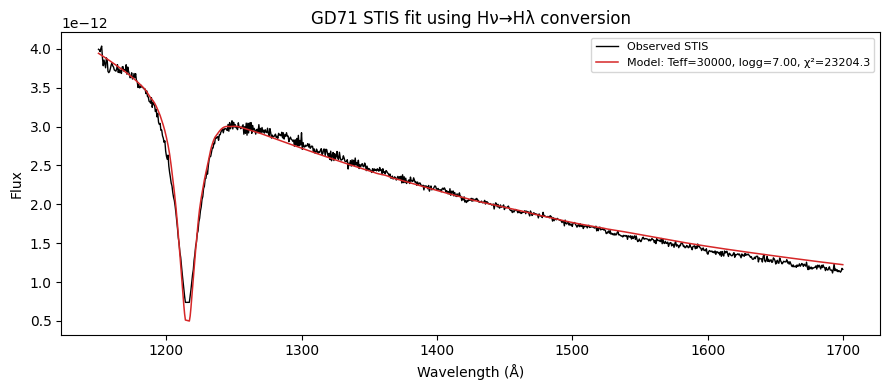

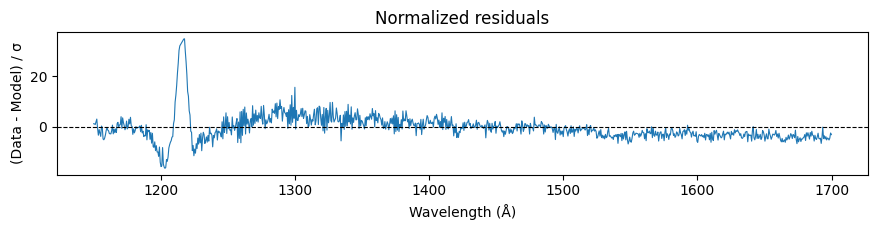

Literature anchors (rough):
  Teff ~ 33000 K, logg ~ 7.80


In [90]:
fit_model = best_fit['scale'] * best_fit['model_hlam'] + best_fit['offset']
residual_sigma = (f - fit_model) / e

plt.figure(figsize=(9, 4))
plt.plot(w, f, color='k', lw=1.0, label='Observed STIS')
plt.plot(
    w,
    fit_model,
    color='tab:red',
    lw=1.1,
    label=f"Model: Teff={best_fit['teff']:.0f}, logg={best_fit['logg']:.2f}, χ²={best_fit['chi2']:.1f}",
)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{TARGET_NAME} STIS fit using Hν→Hλ conversion')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 2.4))
plt.plot(w, residual_sigma, color='tab:blue', lw=0.8)
plt.axhline(0.0, color='k', ls='--', lw=0.8)
plt.xlabel('Wavelength (Å)')
plt.ylabel('(Data - Model) / σ')
plt.title('Normalized residuals')
plt.tight_layout()
plt.show()

print('Literature anchors (rough):')
print(f'  Teff ~ {LIT_TEFF:.0f} K, logg ~ {LIT_LOGG:.2f}')

## 6) Interpretation

- This notebook now follows the Tremblay README convention directly: model files are $H_\nu$ and must be converted to $H_\lambda$ for STIS comparison.
- The fitted `scale` and `offset` are nuisance terms for shape-based validation; they are not physical radius/distance constraints.
- For publication-grade atmospheric parameters, use a richer grid in $(T_{\mathrm{eff}}, \log g)$ and apply recommended 3D corrections.